In [ ]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import scale


test_data= pd.read_csv('test_66516Ee.csv',index_col=0)

data = pd.read_csv('train_ZoGVYWq.csv',index_col=0)

#submission = pd.read_csv('sample_submission_sLex1ul.csv')

print("loaded")

## dealing with unbalanced classes
"""
upsample
data augmentation
trees models
svm
"""

In [ ]:
#unbalance
data[data.renewal==1].renewal.value_counts()

In [ ]:
#upsample
from sklearn.utils import resample

df_majority = data[data.renewal==1]
df_minority = data[data.renewal==0]
 
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=74855,    
                                 random_state=123) 
 
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
df_upsampled.renewal.value_counts()

data = df_upsampled

## data preparation

In [2]:
print(data.shape)
print(test_data.shape)

data.info()
data.describe()

(79853, 12)
(34224, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 79853 entries, 110936 to 71531
Data columns (total 12 columns):
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_days                         79853 non-null int64
Income                              79853 non-null int64
Count_3-6_months_late               79756 non-null float64
Count_6-12_months_late              79756 non-null float64
Count_more_than_12_months_late      79756 non-null float64
application_underwriting_score      76879 non-null float64
no_of_premiums_paid                 79853 non-null int64
sourcing_channel                    79853 non-null object
residence_area_type                 79853 non-null object
premium                             79853 non-null int64
renewal                             79853 non-null int64
dtypes: float64(5), int64(5), object(2)
memory usage: 7.9+ MB


,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


In [3]:
y = data['renewal']
X = data.drop(['renewal'],axis = 1)

In [4]:
# prepare data 


def prepare(X):
    
    #nulls
    # fill na with 0 
    X['application_underwriting_score'].fillna(90,inplace=True)
    X.fillna(0 ,inplace=True)
    
    #fill na with columns missing values  mean 

    #X['Count_3-6_months_late'].fillna(X['Count_3-6_months_late'].mean(),inplace=True)
    #X['Count_6-12_months_late'].fillna(X['Count_6-12_months_late'].mean(),inplace=True)
    #X['Count_more_than_12_months_late'].fillna(X['Count_more_than_12_months_late'].mean(),inplace=True)
    #X['application_underwriting_score'].fillna(X.application_underwriting_score.mean(),inplace=True)
    
    #dropna 
    #data.dropna(how='any',axis=0,inplace=True) 
    
    ## feature eng
    X['late_factor'] = (X['Count_3-6_months_late']*0.3+X['Count_6-12_months_late']*0.3+X['Count_more_than_12_months_late']*0.3)
    
    #X['young_risk'] = ((X['late_factor'])+0.1)/(X['age_in_days'])**0.5
    
    #X.drop(['no_of_premiums_paid'],axis = 1,inplace=True)

    #dummies for categorical columns
    X = pd.get_dummies(X) 
 
    return (X)

X = prepare(X)
test_data = prepare(test_data)

In [5]:
X.head()
test_data.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,late_factor,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
id,,,,,,,,,,,,,,,,,
649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,3300,0.0,1,0,0,0,0,1,0
81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,11700,0.0,1,0,0,0,0,0,1
70762,1.000,17170,186030,0.0,0.0,0.0,90.00,2,11700,0.0,0,1,0,0,0,0,1
53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,5400,0.0,0,1,0,0,0,1,0
15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,9600,0.3,1,0,0,0,0,1,0


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79853 entries, 110936 to 71531
Data columns (total 17 columns):
perc_premium_paid_by_cash_credit    79853 non-null float64
age_in_days                         79853 non-null int64
Income                              79853 non-null int64
Count_3-6_months_late               79853 non-null float64
Count_6-12_months_late              79853 non-null float64
Count_more_than_12_months_late      79853 non-null float64
application_underwriting_score      79853 non-null float64
no_of_premiums_paid                 79853 non-null int64
premium                             79853 non-null int64
late_factor                         79853 non-null float64
sourcing_channel_A                  79853 non-null uint8
sourcing_channel_B                  79853 non-null uint8
sourcing_channel_C                  79853 non-null uint8
sourcing_channel_D                  79853 non-null uint8
sourcing_channel_E                  79853 non-null uint8
residence_area_type

In [7]:
X.describe()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,late_factor,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
count,79853.000000,79853.000000,7.985300e+04,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000
mean,0.314288,18846.696906,2.088472e+05,0.248369,0.078093,0.059935,98.729594,10.863887,10924.507533,0.115919,0.540168,0.206780,0.150765,0.094661,0.007627,0.396604,0.603396
std,0.334915,5208.719136,4.965826e+05,0.691102,0.436251,0.311840,1.864112,5.170687,9401.676542,0.312990,0.498387,0.404999,0.357821,0.292749,0.086997,0.489195,0.489195
min,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,90.000000,2.000000,1200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.750000,7.000000,5400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.180000,10.000000,7500.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.520000,14.000000,13800.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,5.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## missing values

In [8]:
# find nulls

def findnulls(X):
    
    print("nulls in data : " ,X.isnull().values.any())
    nulls = X.isnull().sum()
    print(nulls[nulls > 0])
    print("=====")
    

findnulls(X)
findnulls(test_data)

nulls in data :  False
Series([], dtype: int64)
=====
nulls in data :  False
Series([], dtype: int64)
=====


In [9]:
data.describe()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


## visualization

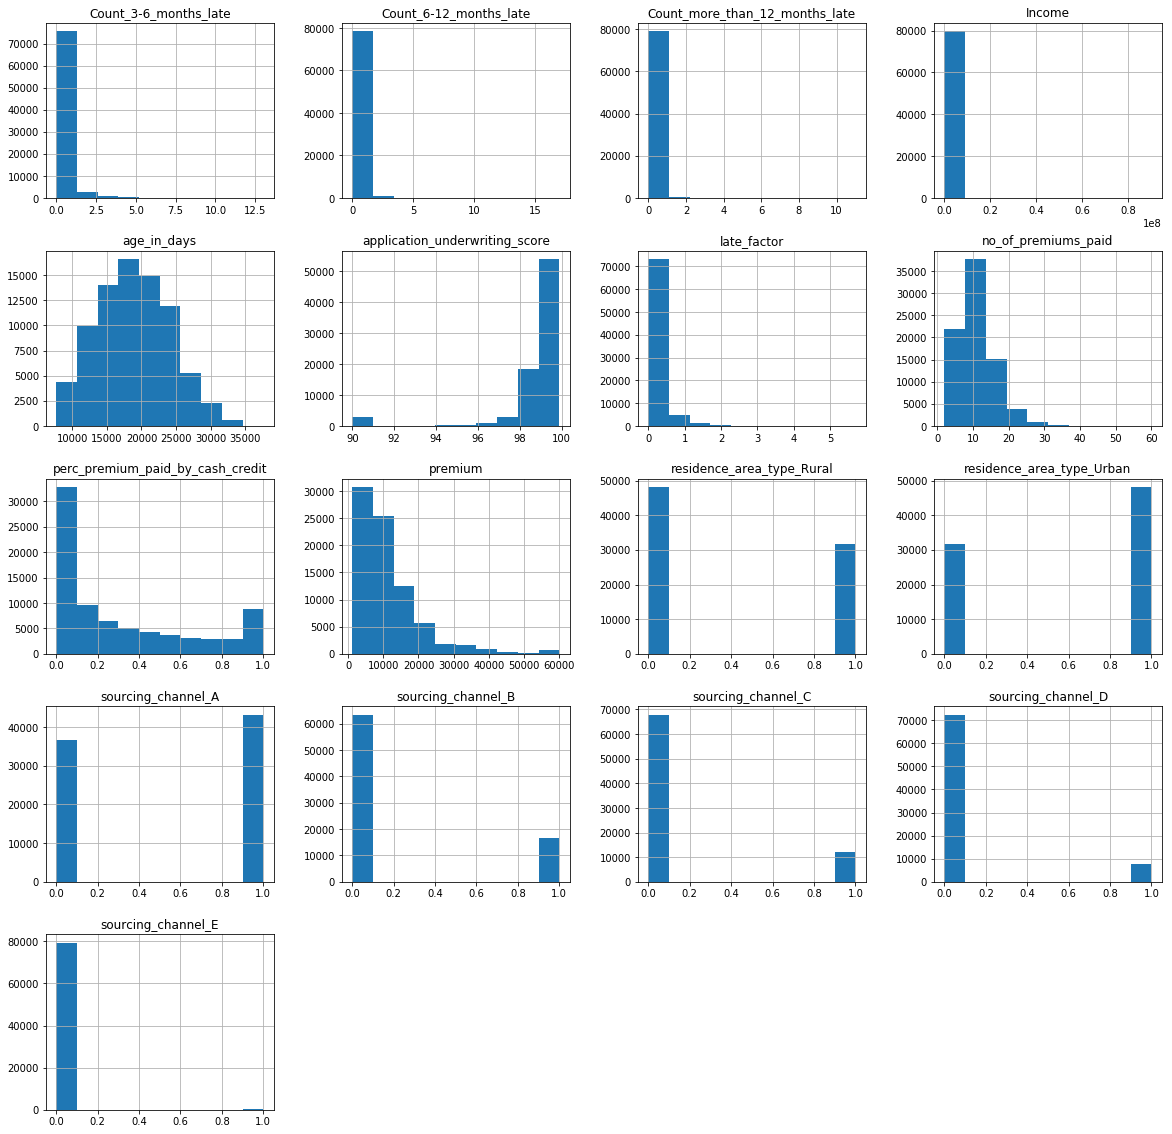

In [12]:
X.hist(figsize = (20, 20))
plt.show()

In [13]:
a = X
b = pd.DataFrame(y)
c = a.merge(b, how='left', on='id' )

cols = c.columns
cols = ['perc_premium_paid_by_cash_credit', 'age_in_days', 'Income',      
       'no_of_premiums_paid',
       'premium', 'renewal']

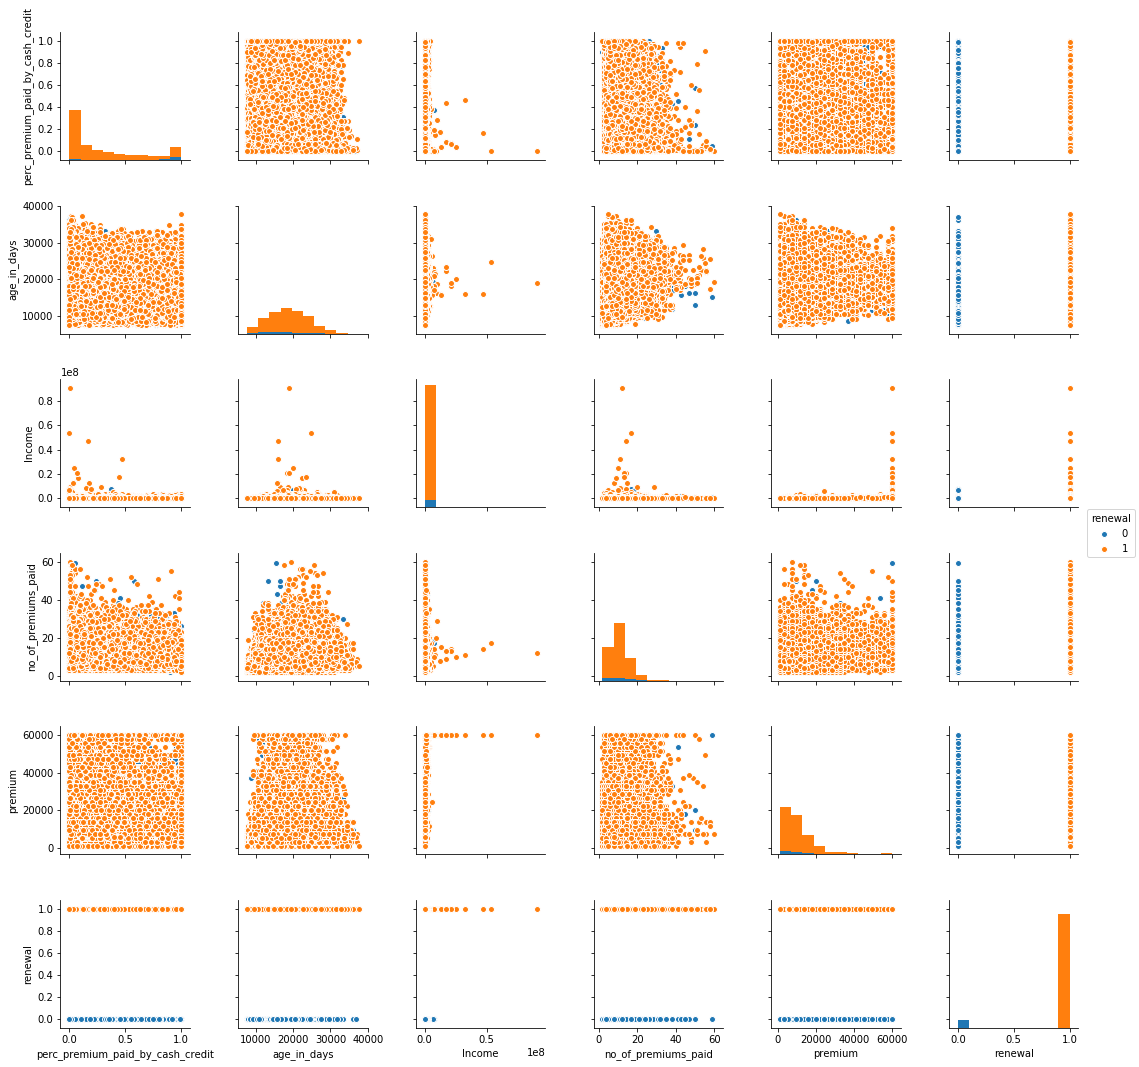

In [14]:
#c_sample= c[cols].sample(frac=0.01)
#g = sns.pairplot(c_sample,hue = 'renewal' ,size=2.5)
g = sns.pairplot(c[cols],hue = 'renewal' ,size=2.5)

In [15]:
c.pivot_table(index=c.columns[-1], values=c.columns[0:-1],aggfunc=np.mean)

,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,Income,age_in_days,application_underwriting_score,late_factor,no_of_premiums_paid,perc_premium_paid_by_cash_credit,premium,residence_area_type_Rural,residence_area_type_Urban,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E
renewal,,,,,,,,,,,,,,,,,
0,0.907563,0.557623,0.347739,177058.799520,16929.642657,98.515304,0.543878,10.410364,0.626626,9599.519808,0.399760,0.600240,0.469988,0.213285,0.180672,0.126851,0.009204
1,0.204355,0.046076,0.040719,210969.651727,18974.696867,98.743902,0.087345,10.894169,0.293433,11012.975753,0.396393,0.603607,0.544853,0.206346,0.148768,0.092512,0.007521


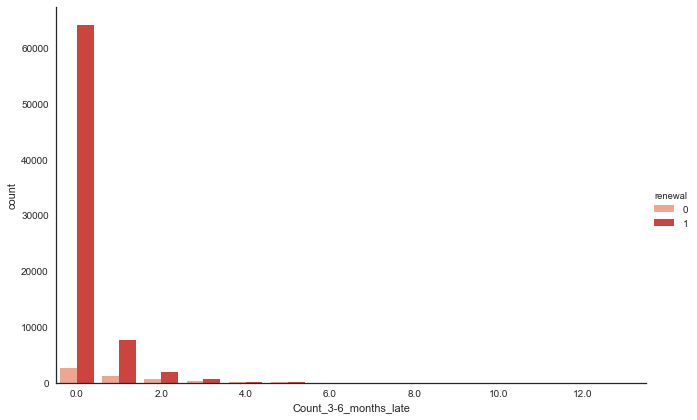

In [16]:
sns.set(style="white")

data = c

g = sns.factorplot(x="Count_3-6_months_late",hue='renewal', data=data, kind="count",
                   palette="Reds", size=6, aspect=1.5)
g.set_xticklabels(step=2)

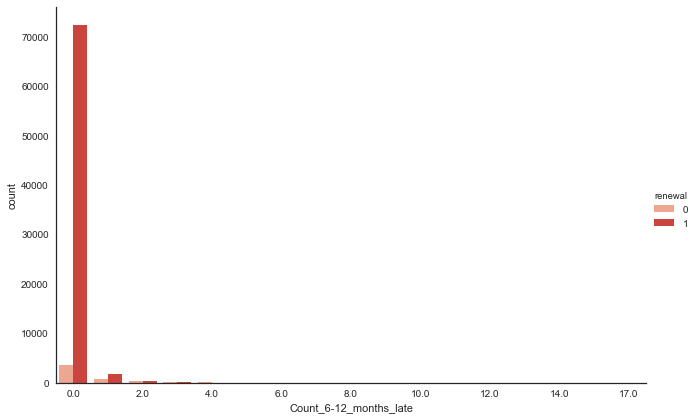

In [17]:
sns.set(style="white")

data = c

g = sns.factorplot(x="Count_6-12_months_late",hue='renewal', data=data, kind="count",
                   palette="Reds", size=6, aspect=1.5)
g.set_xticklabels(step=2)

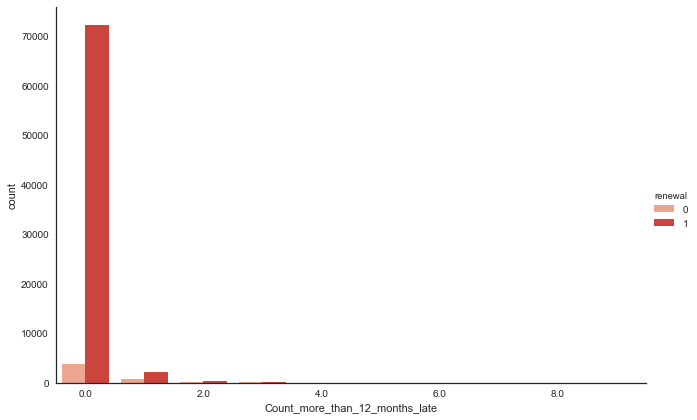

In [18]:
sns.set(style="white")

data = c

g = sns.factorplot(x="Count_more_than_12_months_late",hue='renewal', data=data, kind="count",
                   palette="Reds", size=6, aspect=1.5)
g.set_xticklabels(step=2)

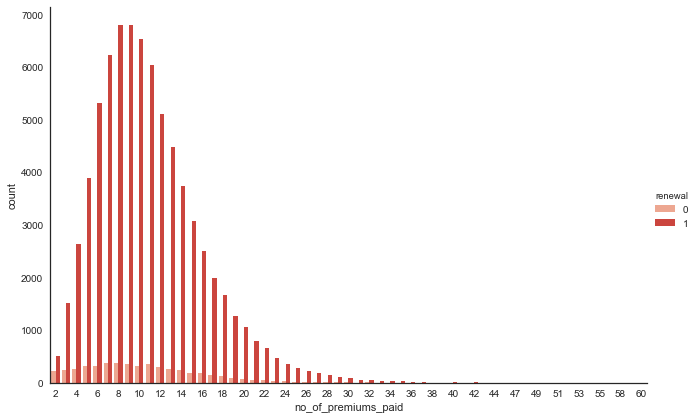

In [19]:
sns.set(style="white")

data = c

g = sns.factorplot(x="no_of_premiums_paid",hue='renewal', data=data, kind="count",
                   palette="Reds", size=6, aspect=1.5)
g.set_xticklabels(step=2)

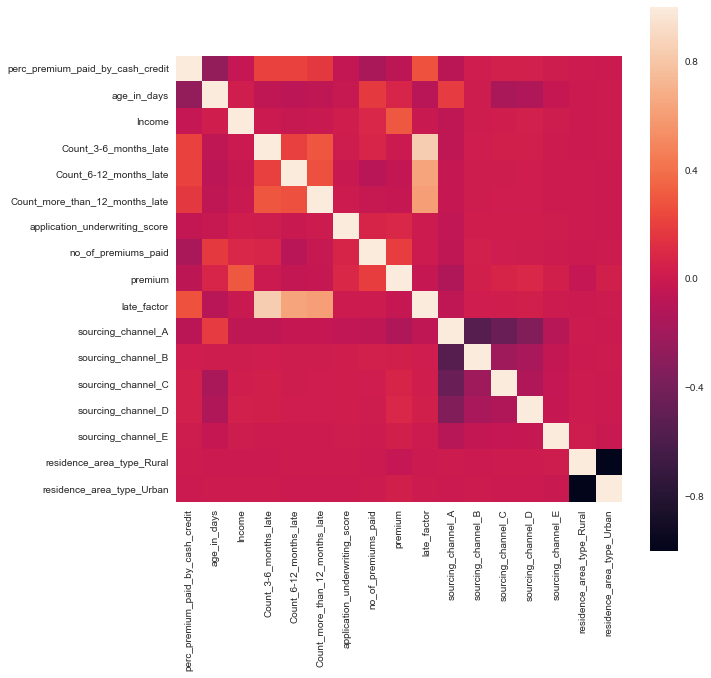

In [20]:
corrmat = X.corr()
fig = plt.figure(figsize = (10, 10))

sns.heatmap(corrmat, square = True)
plt.show()

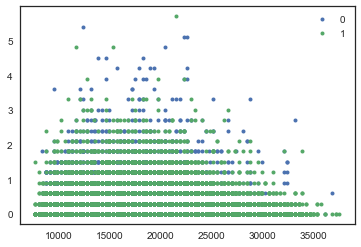

In [21]:
x = c['age_in_days']
z = c['late_factor']
label = c['renewal']

df = pd.DataFrame(dict(x=x, y=z, label=label))

groups = df.groupby('label')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=name)
ax.legend()

plt.show()

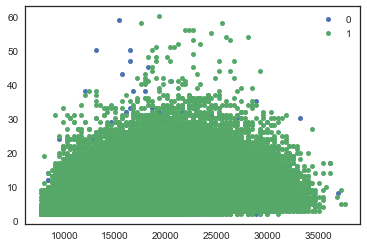

In [22]:
z = c['no_of_premiums_paid']
x = c['age_in_days']
label = c['renewal']

df = pd.DataFrame(dict(x=x, y=z, label=label))

groups = df.groupby('label')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='.', linestyle='', ms=10, label=name)
ax.legend()

plt.show()



In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=27)

# models

## knn

In [ ]:
"""
from sklearn.neighbors import KNeighborsClassifier

neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(k)
    knn.fit(X_train,y_train)
    train_accuracy[i] = knn.score(X_train,y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()
"""

In [ ]:
"""
knn  = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
#knn.fit(X,y)
y_pred = knn.predict_proba(X_test)[:,1]

#print(knn.score(X_test, y_test))

print(roc_auc_score(y_test, y_pred))
"""

## logreg with grids earch/randomized search

In [ ]:
"""
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

logreg = LogisticRegression()


logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

logreg_cv.fit(X_train,y_train)
#logreg_cv.fit(X,y)
y_pred = logreg_cv.predict_proba(X_test)[:,1]


print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

print(roc_auc_score(y_test, y_pred))
"""

In [ ]:
"""
##
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

clf = RandomizedSearchCV(logreg, hyperparameters, random_state=1, n_iter=100, cv=5, verbose=0)

clf.fit(X_train,y_train)

y_pred = clf.predict_proba(X_test)[:,1]

print("Tuned Logistic Regression Parameters: {}".format(clf.best_params_)) 
print("Best score is {}".format(clf.best_score_))

print(roc_auc_score(y_test, y_pred))

"""

In [ ]:
renewal = logreg_cv.predict_proba(test_data)[:,1]



## decision tree

In [ ]:
"""
# decision tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_train,y_train)

y_pred = clf.predict_proba(X_test)[:,1]

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train,y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}' .format(clf.score(X_test, y_test)))

print(roc_auc_score(y_test, y_pred))
"""

## random forest

In [24]:
# random forest
import time 

start_time = time.time()

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators= 400, random_state=0,max_depth = 6 )

clf.fit(X_train,y_train)

y_pred = clf.predict_proba(X_test)[:,1]

print('Accuracy of Decision Tree classifier on training set: {:.2f}' .format(clf.score(X_train,y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}' .format(clf.score(X_test, y_test)))
print(roc_auc_score(y_test, y_pred))
print("===============")
print(clf.feature_importances_)

elapsed_time = time.time() - start_time

print("")
print ("time : " + str(elapsed_time))

Accuracy of Decision Tree classifier on training set: 0.94
Accuracy of Decision Tree classifier on test set: 0.94
0.8402661584845907
[0.14278162 0.02504762 0.02286981 0.07117588 0.23934259 0.10646537
 0.02747891 0.03427035 0.00822128 0.3124851  0.00174505 0.00135593
 0.00138054 0.00240707 0.00064276 0.00107905 0.00125106]

time : 59.97900199890137


In [25]:
renewal = clf.predict_proba(test_data)[:,1]
#test_data.head()

In [ ]:
# random forest gridsearch

param_grid = { 
    'n_estimators': [400,500],
    'max_features': ['auto'],
    'max_depth' : [3,4,5,6],
    'criterion' :['gini']
}

clf=RandomForestClassifier(random_state=0)

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)

CV_clf.fit(X_train,y_train)

y_pred = CV_clf.predict_proba(X_test)[:,1]

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(CV_clf.score(X_train,y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}' .format(CV_clf.score(X_test, y_test)))

print(roc_auc_score(y_test, y_pred))


In [ ]:
renewal = CV_clf.predict_proba(test_data)[:,1]

## Xgboost 

In [26]:
#xgboost
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=2, n_estimators=400, learning_rate=0.05,scale_pos_weight=1.1,min_child_weight = 1)
model.fit(X_train, y_train)
#print(model)
y_pred = model.predict_proba(X_test)[:,1]

print(roc_auc_score(y_test, y_pred))

0.8437547305387982


In [ ]:
#xgboost without split

from xgboost import XGBClassifier

model = XGBClassifier(max_depth=2, n_estimators=400, learning_rate=0.05,scale_pos_weight=1.1,min_child_weight = 1)
model.fit(X, y)
renewal = model.predict_proba(test_data)[:,1]

# part b - incentives

In [28]:
## part b 

y = pd.DataFrame(renewal,columns = ["renewal"], index=test_data.index)
X = test_data
data = X.merge(y , how='left', on='id' )

print(X.shape)
print(y.shape)
print(data.shape)

(34224, 17)
(34224, 1)
(34224, 18)


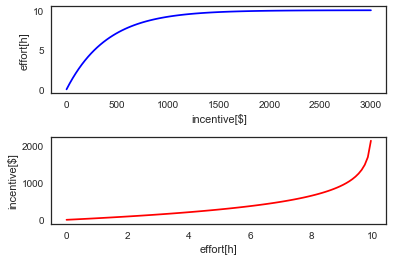

In [29]:
# Equation for the effort-incentives curve: Y = 10*(1-exp(-X/400))
#X = incentive 
#Y = effort

#effort = 10*(1-np.exp(-incentive/400))

# inversed

#incentive = -400*np.log((10-effort)/10)

#  effort - incentive graphs

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.5)

x1 = np.linspace(0, 3000, 100)
x2 = np.linspace(0, 9.95, 100)

y1 = 10*(1-np.exp(-x1/400))
inv = -400*np.log((10-x2)/10)

ax1.plot(x1, y1, 'b')
ax1.set_xlabel('incentive[$]')
ax1.set_ylabel('effort[h]')

ax2.plot(x2, inv, 'r')
ax2.set_xlabel('effort[h]')
ax2.set_ylabel('incentive[$]')

plt.show()

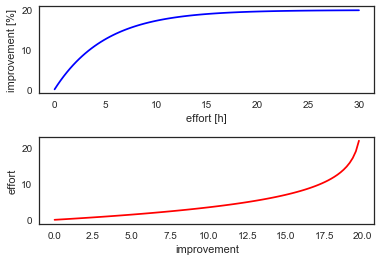

In [30]:
# Equation for the % improvement in renewal prob vs effort curve: Y = 20*(1-exp(-X/5))
#X = effort 
#Y = % improvement

#improvment = 20*(1-np.exp(-effort/5))

# inversed

#effort = -5*np.log((20-improvment)/20)

#  effort - improvement graphs

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.5)

x1 = np.linspace(0, 30, 100)
x2 = np.linspace(0, 19.75, 100)

y1 = 20*(1-np.exp(-x1/5))
inv = -5*(np.log((20-x2)/20))

ax1.plot(x1, y1, 'b')
ax1.set_xlabel('effort [h]')
ax1.set_ylabel('improvement [%]')

ax2.plot(x2, inv, 'r')
ax2.set_xlabel('improvement')
ax2.set_ylabel('effort')

plt.show()

In [31]:
x1 = 10
y1 = 20*(1-np.exp(-x1/5))
print(" max improvement in % : " + str(y1))

x1 = 7.5
y1 = 20*(1-np.exp(-x1/5))
print("improvement for {} hours effort  in % : {}" .format(x1,y1))

 max improvement in % : 17.293294335267746
improvement for 7.5 hours effort  in % : 15.537396797031404


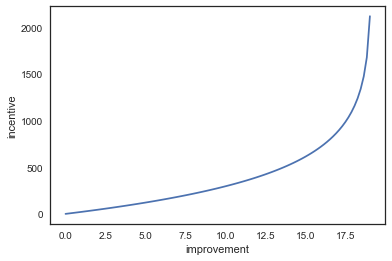

In [32]:
# improvenent- incentive

#effort = -5*np.log((20-improvment)/20)

x = np.linspace(0, 19, 100)

y = -5*np.log((20-x)/20)

#incentive = -400*np.log((10-effort)/10)

y = np.linspace(min(y), 9.95, 100)

z = -400*np.log((10-y)/10)

y = z

#y  = -400*np.log(((np.log((-x/20)+1)/2)+1))

plt.plot(x,y)
plt.xlabel('improvement')
plt.ylabel('incentive')
plt.show()

## incentive improvement graph

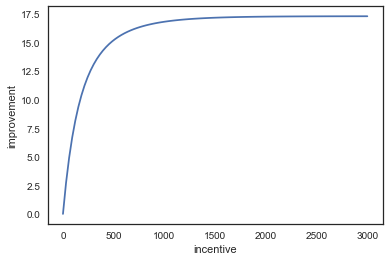

In [33]:
#effort = 10*(1-m.exp(-incentive/400))

x = np.linspace(0, 3000, 100)

y = (10*(1-np.exp(-x/400)))

#improvment = 20*(1-np.exp(-effort/5))

z = 20*(1-np.exp(-(10*(1-np.exp(-x/400)))/5))

plt.plot(x,z)
plt.ylabel('improvement')
plt.xlabel('incentive')
plt.show()

# calculate incentive

In [34]:
#3 different incentive formulas 

def optimize_incentive(renewal,premium):
    
    opt = 0       
    for incentive in range (0,2500,100):
        improvement  = 20*(1-np.exp(-(10*(1-np.exp(-incentive/400)))/5))
        
        if renewal*premium*(1+improvement/100)-incentive > opt :
            opt = incentive           
    return opt 


def complete_incentive (renewal,premium):
    improvement = (1-renewal)*100
    if improvement > 17.29 :
        return 0   
    incentive = -400*np.log(((np.log((-improvement/20)+1)/2)+1))
    return incentive


def complete_plus_incentive (renewal,premium):
    improvement = (1-renewal)*100
    
    if improvement  < 17.29 :
        incentive = -400*np.log(((np.log((-improvement/20)+1)/2)+1))
        
    elif improvement < 50 and premium > 600 : 
        incentive = premium*0.1
        if incentive > 1200 :
            incentive = 400 #[300,400,500,600]        
    else :
        incentive= 0
    
    return incentive


"""
r = 0.85 #renewal
k = 750 # premium

optimized = optimize_incentive(r,k)
comp = complete_incentive(r,k)
comptwo = complete_plus_incentive(r,k)

print(optimized)
print(comp)
print(comptwo)
"""

'\nr = 0.85 #renewal\nk = 750 # premium\n\noptimized = optimize_incentive(r,k)\ncomp = complete_incentive(r,k)\ncomptwo = complete_plus_incentive(r,k)\n\nprint(optimized)\nprint(comp)\nprint(comptwo)\n'

In [35]:
d = data

d['incentives'] = d.apply(lambda x: optimize_incentive(x['renewal'],x['premium']),axis=1)
d['incentive_comp'] = d.apply(lambda x: complete_incentive(x['renewal'],x['premium']),axis=1)
d['incentive_plus_comp'] = d.apply(lambda x: complete_plus_incentive(x['renewal'],x['premium']),axis=1)

#create net revenue

d['revenue'] = d.apply(lambda x: -500+x['premium']*x['renewal']*(1+20*(1-np.exp(-(10*(1-np.exp(-500/400)))/5))/100), axis = 1 )
d['revenue_opt'] = d.apply(lambda x: -x['incentives']+x['premium']*x['renewal']*(1+20*(1-np.exp(-(10*(1-np.exp(-x['incentives']/400)))/5))/100), axis = 1 )
d['revenue_comp'] = d.apply(lambda x: -x['incentive_comp']+x['premium']*x['renewal']*(1+20*(1-np.exp(-(10*(1-np.exp(-x['incentive_comp']/400)))/5))/100), axis = 1 )
d['revenue_comp_plus'] = d.apply(lambda x: -x['incentive_plus_comp']+x['premium']*x['renewal']*(1+20*(1-np.exp(-(10*(1-np.exp(-x['incentive_plus_comp']/400)))/5))/100), axis = 1 )


In [36]:
d.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,late_factor,...,residence_area_type_Rural,residence_area_type_Urban,renewal,incentives,incentive_comp,incentive_plus_comp,revenue,revenue_opt,revenue_comp,revenue_comp_plus
id,,,,,,,,,,,,,,,,,,,,,
649,0.001,27384,51150,0.0,0.0,0.0,99.89,7,3300,0.0,...,1,0,0.992667,1900,7.541816,7.541816,3273.701776,1940.746139,3292.280717,3292.280717
81136,0.124,23735,285140,0.0,0.0,0.0,98.93,19,11700,0.0,...,0,1,0.987951,2400,12.623982,12.623982,12815.933433,11156.412952,11685.677526,11685.677526
70762,1.000,17170,186030,0.0,0.0,0.0,90.00,2,11700,0.0,...,0,1,0.802903,2400,0.000000,1170.000000,10321.796577,8617.233153,9393.969941,9819.688120
53935,0.198,16068,123540,0.0,0.0,0.0,99.00,11,5400,0.0,...,1,0,0.979201,2400,22.587546,22.587546,5591.382841,3801.390361,5375.076467,5375.076467
15476,0.041,10591,200020,1.0,0.0,0.0,99.17,14,9600,0.3,...,1,0,0.966507,2400,38.446097,38.446097,10188.735675,8481.769234,9550.784663,9550.784663


In [37]:
# total net revenue

total_net_rev = sum(d.revenue)
total_net_rev2 = sum(d.revenue_opt)
comp= sum(d['revenue_comp'])
compt=sum(d['revenue_comp_plus'])



print(total_net_rev)
print(total_net_rev2)
print(comp)
print(compt)





388648262.15784514
338959527.6449104
360737146.6280582
361640033.8850259


## prepare for submission 



In [ ]:
d['incentives'] = d['revenue_comp_plus']

In [ ]:
d.head()

In [ ]:
f = d[['renewal','incentives']]

In [ ]:
f.to_csv("submission.csv")
